# Amperometric Signal Processing Software for Zhang Lab Research 

                
## Chris McAllister
*Up to date as of 8/12/20*

### *Importing Modules*

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks
from scipy.signal import peak_widths

In [4]:
testfile = '/mnt/b/Zhang Lab/Data/NP Encapsulation July 2020/7.5.20/60nm_Ag_NP_collisions_CFE1_0.22_psi_a1_b1_7.5.20.txt'
testfile2 = '/mnt/b/Zhang Lab/Data/NP Encapsulation July 2020/8.6.20/AgNP_Seed_soln_600mV_CFE01_a1b1_8_6_20_end.txt'

#### *DataFrames Included for Reference*
* First column represents time axis (seconds)
* Second column represents y axis (pA)

In [ ]:
df = pd.read_csv(testfile, sep = '\t', header = None)
df

In [ ]:
df2 = pd.read_csv(testfile2, sep = '\t', header = None)
df2

In [ ]:
test_y = df[1]
test_y2 = df2[1]

### *Baseline Correction*

In [5]:
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [ ]:
y = baseline_als_optimized(test_y, 10000000, 0.001)

### *Peak detection*

Fast, automated functions for finding peak coordinates, heights, and frequency in an amperometric trace. 

In [6]:
def peak_detector(file, SNR, wval, gain_adj, zoom = False):
    """Function which uses scipy peak detector to find peaks within a
    set of NP collision data.

    Input: .txt file (typically converted from .atf file format)
    NO HEADER ONLY DATA [That means delete all information except
    for the current and time values], desired signal to noise ratio of peaks,
    width value of peak (wval; tuneable), gain_adjustment value.
    If zoom = True:
    the plotted graph will be zoomed to the 300 ms interval with
    the highest density of detected peaks.

    Output: number of peaks, frequency, and average half-width are
    read out to screen; array of peak indices is output;
    optional: plot zoomed to show interval of highest peak density
    -------------------------------------------------------------------------"""
    # Loading file into a dataframe
    df = pd.read_csv(file, sep="\t", header=None)
    # Gain adjustment
    df['gain_adj_y'] = df[1] * gain_adj
    # Finding Baseline
    bline = baseline_als_optimized(df['gain_adj_y'], 10e7, 0.001)
    # Setting height threshold based on desired S/N Ratio
    hthresh = bline + SNR * df['gain_adj_y'].std()
    # Using scipy.signal.find_peaks() to analyze current data
    peaks = find_peaks(df['gain_adj_y'], height=hthresh, width=wval)
    # obtaining/adjusting coordinate axes (dt = 0.01 ms)
    min_x_ind = np.min(df[0])/0.00001
    xcoords = (peaks[0] + min_x_ind) * 0.00001
    ycoords = peaks[1]['peak_heights']
    peak_indices = peaks[0]
    # Finding average peak height
    av_ph = np.mean(ycoords)
    # Calculate number of peaks
    npeaks = len(xcoords)
    freq = npeaks/(np.max(df[0]) - np.min(df[0]))

    # Find period of time with most peaks using histogram function
    # Determining number of bins (based on 300 ms window)
    nbins = int(np.max(xcoords)/0.3)
    # compute histogram
    pop, left_edges = np.histogram(xcoords, nbins)
    # Find zoom window
    max_pop = np.max(pop)
    max_ind = pop.argmax()
    right_edge = max_ind + 1
    xmin = left_edges[max_ind]
    xmax = left_edges[right_edge]

    # Plotting original trace
    plt.plot(df[0],df['gain_adj_y'])
    # Adding points to graph
    plt.scatter(xcoords,ycoords, c = 'red')
    # Labeling axes
    plt.ylabel('Current (pA)')
    plt.xlabel('Time(s)')
    if zoom is True:
        plt.xlim(xmin, xmax)
    else:
        pass

    print("\nTotal number of detected peaks: " + str(npeaks))
    print('\nFrequency of peaks (Hz): ' + str(freq))
    print("\nAverage peak height (pA): " + str(av_ph))
    return [npeaks, freq, peak_indices, df['gain_adj_y'], bline]


Total number of detected peaks: 29

Frequency of peaks (Hz): 0.9685873754321488

Average peak height (pA): 178.5185275862069
CPU times: user 20.9 s, sys: 13.5 s, total: 34.4 s
Wall time: 34.1 s


[29,
 0.9685873754321488,
 array([ 231665,  287457,  287459,  465046,  465049,  465169,  475579,
         724313,  724681,  724683,  725093,  735316,  735318,  735321,
         735325,  735327,  735329,  735712, 1746894, 1746897, 1754578,
        1756108, 1756110, 1909959, 1916244, 1916250, 2155333, 2230249,
        2230254]),
 0         -2.62803
 1         -2.62803
 2         -2.62803
 3         -5.67979
 4         -5.67979
             ...   
 2994047   -1.94360
 2994048   -1.94360
 2994049   -1.94360
 2994050   -1.94360
 2994051   -1.94360
 Name: gain_adj_y, Length: 2994052, dtype: float64,
 array([ -5.2866168 ,  -5.28979181,  -5.29296683, ..., -16.70260726,
        -16.70669852, -16.71078978])]

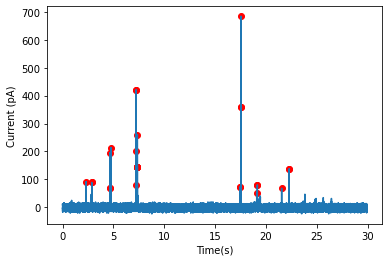

In [7]:
%%time
peak_detector(testfile, 10, 35, 10)


Total number of detected peaks: 29

Frequency of peaks (Hz): 0.9685873754321488

Average peak height (pA): 178.5185275862069
CPU times: user 20.9 s, sys: 13.9 s, total: 34.8 s
Wall time: 34.5 s


[29,
 0.9685873754321488,
 array([ 231665,  287457,  287459,  465046,  465049,  465169,  475579,
         724313,  724681,  724683,  725093,  735316,  735318,  735321,
         735325,  735327,  735329,  735712, 1746894, 1746897, 1754578,
        1756108, 1756110, 1909959, 1916244, 1916250, 2155333, 2230249,
        2230254]),
 0         -2.62803
 1         -2.62803
 2         -2.62803
 3         -5.67979
 4         -5.67979
             ...   
 2994047   -1.94360
 2994048   -1.94360
 2994049   -1.94360
 2994050   -1.94360
 2994051   -1.94360
 Name: gain_adj_y, Length: 2994052, dtype: float64,
 array([ -5.2866168 ,  -5.28979181,  -5.29296683, ..., -16.70260726,
        -16.70669852, -16.71078978])]

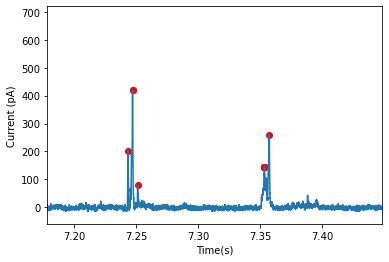

In [10]:
%%time
peak_detector(testfile, 10, 35, 10, zoom = True)


Total number of detected peaks: 106

Frequency of peaks (Hz): 1.0563681008325279

Average peak height (pA): 34.06677169811321
CPU times: user 1min 18s, sys: 1min 9s, total: 2min 27s
Wall time: 2min 23s


[106,
 1.0563681008325279,
 array([ 361486,  439418,  466185,  570269,  685617,  803746,  803749,
         844759,  847664,  847666,  848007,  848178,  870007,  900089,
         914590, 1000634, 1007870, 1062588, 1107376, 1108124, 1129671,
        1129751, 1136899, 1137577, 1137581, 1153312, 1203210, 1227120,
        1276584, 1287524, 1327292, 1337338, 1339314, 1422309, 1512186,
        1540789, 1574102, 1614683, 1680208, 1732172, 1758643, 2065337,
        2184812, 2195217, 2358024, 2408306, 2448331, 2448595, 2621183,
        2673769, 2677898, 2699507, 2738796, 2899697, 3210130, 3243276,
        3357076, 3357253, 3525777, 3543265, 3543348, 3661098, 3666700,
        3773030, 3774787, 3830150, 3869049, 3870860, 3870920, 4048415,
        4117984, 4211873, 4248863, 4392127, 4514819, 4636484, 4969113,
        4971783, 5164900, 5183499, 5201575, 5204077, 5213274, 5232948,
        5776593, 5776662, 5776798, 6229412, 6912948, 6913092, 6986599,
        7733913, 7839139, 7840948, 8006324, 800658

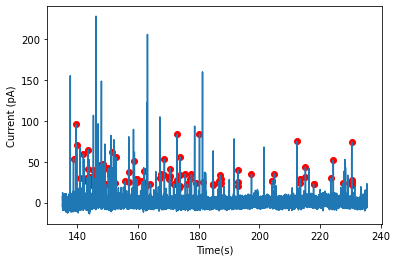

In [14]:
%%time 
peak_detector(testfile2, 10, 20, 10)

### *Half-Width* 

In [11]:
def find_half_widths(file, SNR, wval, gain_adj):
    '''Function which uses scipy.signal.peak_widths to find the
    half-widths of peaks detected within an amperometry trace

    Input: .txt file (typically converted from .atf file format)
    NO HEADER ONLY DATA, desired signal to noise ratio of peaks

    Output: number of peaks, frequency, and average half-width
    are read out to screen; half-width array in milliseconds is output
    ---------------------------------------------------------------------'''
    # Using Peak Detector to get Peaks
    n, f, ind, amps, bline = peak_detector(file, SNR, wval, gain_adj)
    # Loading file into a dataframe
    df = pd.read_csv(file, sep="\t", header=None)
    # Use scipy.signal.peak_widths on data (half-height)
    hws, rel_h, left, right = peak_widths(df[1], ind, rel_height = 0.5)
    # Adjust halfwidths to ms time scale
    halfwidths = hws * 0.01
    av_hw = np.mean(halfwidths)
    print("\nAverage Half-width (ms): " + str(av_hw))
    return halfwidths


Total number of detected peaks: 29

Frequency of peaks (Hz): 0.9685873754321488

Average peak height (pA): 178.5185275862069

Average Half-width (ms): 0.6810961686297529
CPU times: user 21.8 s, sys: 13.1 s, total: 34.9 s
Wall time: 34.5 s


array([0.57742533, 0.51002982, 0.51002982, 0.37249991, 0.37249991,
       0.44416536, 0.35867912, 0.52333403, 0.58016177, 0.58016177,
       0.69000011, 1.13000147, 1.13000147, 1.13000147, 1.13000147,
       1.13000147, 1.13000147, 1.1666679 , 0.52499762, 0.52499762,
       0.51839849, 0.41249963, 0.41249963, 1.06999885, 0.54745859,
       0.54745859, 0.78747866, 0.47016876, 0.47016876])

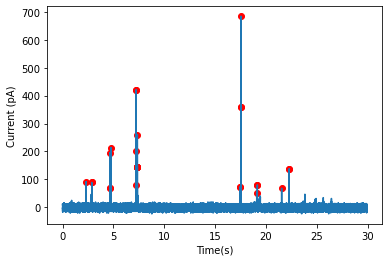

In [12]:
%%time
find_half_widths(testfile, 10, 35, 10)


Total number of detected peaks: 36

Frequency of peaks (Hz): 1.2023843281226674

Average peak height (pA): 168.2473861111111

Average Half-width (ms): 0.6115311661015018
CPU times: user 21.8 s, sys: 13.7 s, total: 35.5 s
Wall time: 35.5 s


array([0.57742533, 0.51002982, 0.51002982, 0.37249991, 0.37249991,
       0.44416536, 0.3300002 , 0.3300002 , 0.35867912, 0.52333403,
       0.24      , 0.34      , 0.34      , 0.34      , 0.58016177,
       0.58016177, 0.69000011, 1.13000147, 1.13000147, 1.13000147,
       1.13000147, 1.13000147, 1.13000147, 0.3433327 , 1.1666679 ,
       0.52499762, 0.52499762, 0.51839849, 0.41249963, 0.41249963,
       1.06999885, 0.54745859, 0.54745859, 0.78747866, 0.47016876,
       0.47016876])

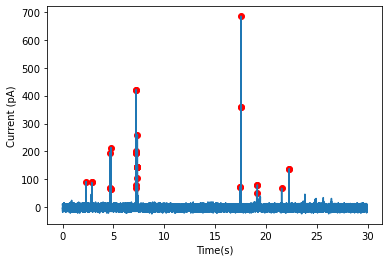

In [16]:
%%time
find_half_widths(testfile, 10, 15, 10)

### *Peak Area*

In [24]:
def calc_peak_area(file, SNR, wval, gain_adj):
    '''Function which uses scipy.signal.peak_widths to find the bounds of peaks
    detected within an amperometry trace and consequently calculates peak area
    using Simpson Integration (trapezoidal approximation)

    Input: .txt file (typically converted from .atf file format)
    NO HEADER ONLY DATA, desired signal to noise ratio of peaks

    Output: list of peak areas for each peak in the dataset
    ----------------------------------------------------------------'''
    # Creating Array output for peak areas
    peak_areas = []
    # Using Peak Detector to get Peaks
    n, f, ind, amps, bline = peak_detector(file, SNR, wval, gain_adj)
    # Loading file into a dataframe
    df = pd.read_csv(file, sep="\t", header=None)
    # Gain adjustment
    df['gain_adj_y'] = df[1] * gain_adj
    # Defining baseline as a horizontal line at y = mean of data set (will need to update)
    b = df['gain_adj_y'].mean()
    # Use scipy.signal.peak_widths on data (full height)
    hws, rel_h, left, right = peak_widths(df[1], ind, rel_height = 0.95)
    # Round left/right indices to callable integers
    left = left.astype(int)
    right = right.astype(int)
    # Iterating over each peak to calculate peak area
    for i in range(len(ind)):
        # Setting arrays needed for Simpson integration function
        y0 = df['gain_adj_y'].iloc[left[i]:right[i]]
        x0 = df[0].iloc[left[i]:right[i]]
        # Setting bounds for baseline integration
        xi = df[0][left[i]]
        xf = df[0][right[i]]
        # Integrate current trace
        T = scipy.integrate.simps(y0, x0)
        # Integrate baseline (assuming baseline is constant)
        B = b * (xf - xi)
        # Adding peak area to new array
        area = (T - B) * 1000
        peak_areas.append(area)
    # Replacing negative values with NaN
    peak_areas = np.asarray(peak_areas)
    peak_areas = np.where(peak_areas < 0, np.nan, peak_areas)
    # Computing average value
    av_pa = np.nanmean(peak_areas)
    std_pa = np.nanstd(peak_areas)
    print("\nAverage peak area (fC): " + str(av_pa)
         + ' +/- ' + str(std_pa))
    return peak_areas


Total number of detected peaks: 29

Frequency of peaks (Hz): 0.9685873754321488

Average peak height (pA): 178.5185275862069

Average peak area (fC): 241.61833561634012 +/- 151.6089539877237
CPU times: user 21.9 s, sys: 13.8 s, total: 35.8 s
Wall time: 36.2 s


array([320.22864772, 223.18642965, 223.18642965,  49.87730417,
        49.87730417, 240.21762108, 113.4900908 , 105.95992204,
       420.12374891, 420.12374891, 132.10314729, 320.08140765,
       320.08140765, 320.08140765, 320.08140765, 320.08140765,
       320.08140765, 658.9727504 ,  39.61041064,  39.61041064,
       482.97889409, 160.44555708, 160.44555708,  54.03709099,
       389.08200276, 389.08200276, 156.93074977, 128.4367332 ,
       128.4367332 ])

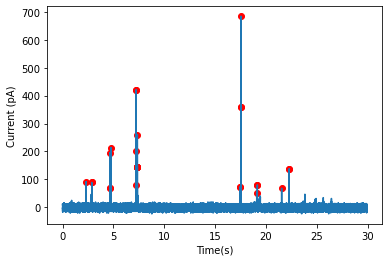

In [25]:
%%time
charges = calc_peak_area(testfile, 10, 35, 10)
charges

In [ ]:
%%time
calc_peak_area(testfile2, 10, 50, 10)

### *Calculating Particle Size*

In [22]:
def calc_particle_diameters(array, unit, metal):
    """Takes an array of calculated charges from an amperometric
    trace and estimates the radius based on the atomic mass and density
    of the given metal.

    Inputs: array of charges,
    [THE FOLLOWING MUST BE STRINGS]
    unit of charge (prefix lowercase, suffix uppercase;
    i.e. fC [femtocoulomb], pC [picocoulomb]),
    type of metal (element symbol i.e. Ag (silver))

     Outputs: array of particle sizes in nm
     ----------------------------------------------------------------------"""
    # Organizing tuneable values into a dictionary
    # Adjusting for unit prefix so that final result is in centimeters
    unit_dict = {"fC" : 10**-15,
                "pC": 10**-12,
                "nC": 10**-9}
    # Atomic mass in g/mol
    atom_mass_dict = {"Ag" : 107.868,
                     "Au" : 196.966,
                     "Pt" : 194.965}
    # Density in g/cm^3
    density_dict = {"Ag" : 10.49,
                   "Au" : 19.32,
                   "Pt" : 21.45}
    # Defining Faraday's Constant (C/mol)
    F = 96500
    # Defining values for calculation
    am = atom_mass_dict[metal]
    dens = density_dict[metal]
    # Adjusting input unit to coulombs
    charges = array * unit_dict[unit]
    # Calculating radii
    num = charges * 3 * am
    denom = 4 * 3.1415 * dens * F
    rads = (num/denom)**(1/3) / 10**-7
    av_rad = np.nanmean(rads)
    std_rads = np.nanstd(rads)
    print("Average estimated particle radius (nm): " + str(av_rad)
         + ' +/- ' + str(std_rads))
    return rads

In [23]:
calc_particle_diameters(charges, "fC", "Ag")

Average estimated particle radius (nm): 17.376596111261968 +/- 4.194974143890383


array([20.12139416, 17.83996247, 17.83996247, 10.82610742, 10.82610742,
       18.28267035, 14.2393661 , 13.91720053, 22.02742606, 22.02742606,
       14.97875542, 20.11830977, 20.11830977, 20.11830977, 20.11830977,
       20.11830977, 20.11830977, 25.59335143, 10.02554036, 10.02554036,
       23.07530193, 15.98136633, 15.98136633, 11.11907506, 21.47097283,
       21.47097283, 15.86380482, 14.83887894, 14.83887894])

### *Plotting + Reporting Basics* UNFINISHED
Simple plotting functions for data presentation. 

In [ ]:
def report_mean_sem(data_column, unit):
    mean_val = data_column.mean()
    sem_val = data_column.sem()
    print("Mean value of column: " + str(mean_val_unit))
    print("Std. Error of Mean: " + str(sem_val))
    return mean_val, sem_val

In [ ]:
def report_hist(data_column, value, unit):
    hist = plt.hist(data_column, bins = 50, density = True)
    plt.title('Distribution of ' + str(value) + ' Values')
    plt.xlabel(str(value) + ' ' + str(unit))
    plt.ylabel("Density")
    return hist